In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt

sys.path.append('../')

from src.explainers import normalized_deltas
import importlib
import src
importlib.reload(src.utils)
from src.utils import attrib_barplot

In IPython Kernel
In IPython Kernel
In IPython Kernel


### Scoring Class Partitioning

Assume that, for a model $\mathcal{M}$ which we are to explain, we are given an attribute $x_S$ and a set of attribute evidence scores for each class $k \in \mathcal{V}$, i.e., $P_{\mathcal{M}}(X_{S} =x_s\mid Y = 1), \dots, P_{\mathcal{M}}(X_{S} =x_s\mid Y = K)$, let $s_i := P_{\mathcal{M}}(X_{S}=x_s \mid Y = i)$, and let $\mathbf{s}$ be the vector with these scores as entries. Suppose, in addition, that the model has predicted class $c^*$.

We define the regularized delta-drop scoring function as:
$$
\begin{equation}\label{eq:delta_scoring}
	F(C; x_S) = \min_{i \in C} s_i - \max_{j \in \bar{C}} s_j + \alpha \Omega(|C|)
\end{equation}
$$
where $\Omega$ is a penalty on the cardinality of $C$.

Possibilities for $\Omega$:
* **polynomial decay**: $\Omega(C) = |C|^{-p}$ : Penalizes larger sets less (but needs correction to avoid taking too large classes, see below) 
* **polynomial centered**: $\Omega(C) = \frac{\bigl||C| - \xi \bigr|^p}{M} $, where $\xi$ is the ideal cardinality size, e.g. $\xi = |C|/2$ and $M$ is a normalizing constant chosen so that $\max_{C \subseteq V} \Omega(C)=1$. Penalty is minimal when close to optimal size $\xi$, grows symmetrically for larger or smaller sets.

But note that we might want to \textit{strictly} rule out partitions where the predicted class belongs to the majority partition, in which case we can use 
$
\Omega(C) =
	\begin{cases}
			\frac{1}{|C|^p} & \mbox{ if } |C| \leq \frac{|V|}{2} \\
			\infty & \mbox{ if } |C| > \frac{|V|}{2}
	\end{cases}
$
and analogously for the centered criterion

### Set problem variables

In [2]:
k = 10
classes = np.array(range(k))
pred = 3
p = 2

### Plot penalty functions

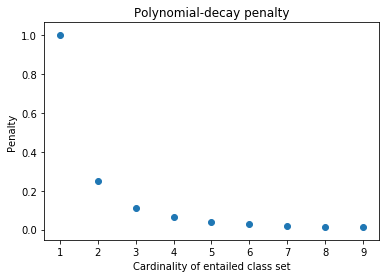

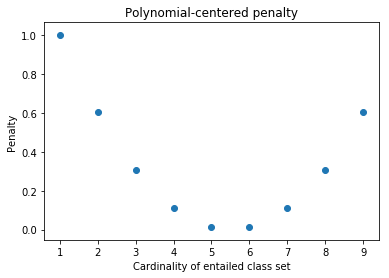

In [3]:
Cards = np.arange(1,k)

# poly decay
reg = 1/np.power(Cards,p)
plt.scatter(Cards,reg)
plt.xlabel('Cardinality of entailed class set')
plt.ylabel('Penalty')
plt.title('Polynomial-decay penalty')
plt.show()

# poly decay
argmin = (k+1)/2
maxp   = max(np.abs((1 - argmin))**p, np.abs((len(Cards) - argmin))**p)
reg = (np.abs((Cards - argmin))**p)/maxp
plt.scatter(Cards,reg)
plt.xlabel('Cardinality of entailed class set')
plt.ylabel('Penalty')
plt.title('Polynomial-centered penalty')
plt.show()

### Evaluate Scoring Functions on Sythetic Data

In [4]:
np.set_printoptions(precision=2)

In [5]:
def compare_criteria(s, pred= 1, alpha = 1, p = 2):
    fig, ax = plt.subplots(1,2)    
    sorted_s = s.copy()
    sorted_s[::-1].sort()
    arridx = s.argsort()[::-1]
    classes_sort = classes[arridx]
    # Call scoring function 
    m, C = normalized_deltas(s, pred, alpha=alpha, p=p, reg_type = 'decay', include_pred = False, V = classes)
    print('Decay Criterion. Score: {:8.2f}, Selected Classes: {}'.format(m, C))
    attrib_barplot(sorted_s, C, classes_sort, topk=10, sort_bars = True, pc = m, ax = ax[0])
    ax[0].set_title("Poly Decay Criterion")
    m, C = normalized_deltas(s, pred, alpha=alpha, p=p, reg_type = 'poly-centered',include_pred = False,  V = classes)
    print('Poly Symmetric Criterion. Score: {:8.2f}, Selected Classes: {}'.format(m, C))
    attrib_barplot(sorted_s, C, classes_sort, topk=10, sort_bars = True, pc = m, ax = ax[1])
    ax[1].set_title("Poly Centered Criterion")
    plt.show()

A sharp histogram has a high score under either this criterion (with either type of regularization):

Individual Class Evidences:  [1 1 1 1 1 0 0 0 0 0]
Decay Criterion. Score:     0.96, Selected Classes: [4 3 2 1 0]
Poly Symmetric Criterion. Score:     0.99, Selected Classes: [4 3 2 1 0]


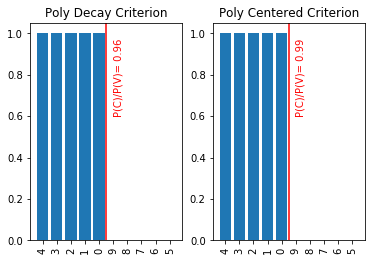

In [6]:
s = np.array(5*[1] + 5*[0])
print('Individual Class Evidences: ', s)
compare_criteria(s)

A flat histogram should be uniformly partitioned too:

Decay Criterion. Score:    -0.04, Selected Classes: [9 8 7 6 5]
Poly Symmetric Criterion. Score:    -0.01, Selected Classes: [9 8 7 6 5]


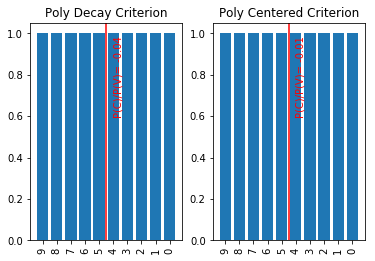

In [7]:
s = np.array(10*[1])
compare_criteria(s)

Strong cardinality regularization (high $\alpha$) will aggresively encourage balanced entailment sets, even at the cost of clear delta partitioning:

Decay Criterion. Score:    -0.18, Selected Classes: [1 7 3 5 8]
Poly Symmetric Criterion. Score:    -0.04, Selected Classes: [1 7 3 5 8]


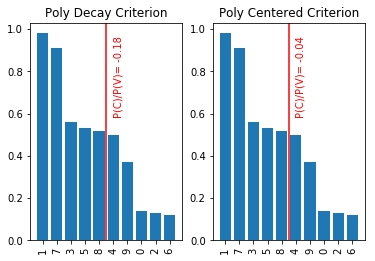

In [8]:
s = np.array([0.14,0.98,0.13,0.56,0.5,0.53,0.12,0.91,0.52,0.37])
compare_criteria(s, alpha = 5)

While small regularization prefers the clear-cut partitions:

Decay Criterion. Score:     0.30, Selected Classes: [1 7]
Poly Symmetric Criterion. Score:     0.23, Selected Classes: [1 7]


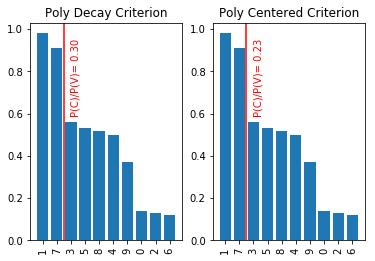

In [9]:
compare_criteria(s, alpha = 0.2, p = 2)

### Sandbox: Compare score profiles for random histograms

[0.84 0.35 0.32 0.06 0.6  0.34 0.17 0.41 0.07 0.07]
Decay Criterion. Score:    -0.02, Selected Classes: [0 4 7 1 5]
Poly Symmetric Criterion. Score:     0.01, Selected Classes: [0 4 7 1 5]


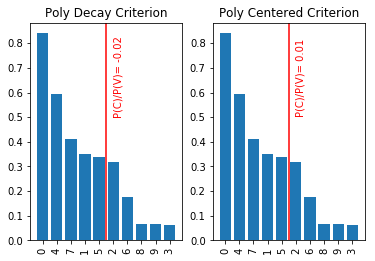

In [10]:
s = np.random.uniform(size=k)
print(s)

compare_criteria(s)